<a href="https://colab.research.google.com/github/aafaf-arharas/Drawings-Classification/blob/main/Challenge_I.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge Deep Learning




> HIBA ELHAYEL - AAFAF ARHARAS




## **Contexte**

L'objectif de ce challenge est de proposer une méthode de classification, basée sur des réseaux de neurones, permettant de classer des images issues de Google Quickdraw (https://quickdraw.withgoogle.com/data). Le jeu de données proposé comprend 5 classes balancées, avec 15000 exemples d'apprentissage et 5000 exemples de validation : des paniers, des yeux, des lunettes, des lapins et des mains.

##**Méthodologie suivie**

Afin de réussir ce challenge, on va suivre les étapes de base suivantes :

*   Importer les images d'entrées nécessaires pour l'entrainement et la validation et les transformer en matrice de pixels
*   Normaliser les valeurs des pixels de l'image (diviser par 255)
*   Construire une architecture modèle (séquentiel) avec différentes couches 

*   Entraîner le modèle
*   Evaluer le modèle sur les données tests











#Importation des bibliothèques

In [ ]:
import tensorflow
import pandas as pd
import numpy as np
import time
from PIL import Image
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2 
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras import layers
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

# Préparation des données

Vu que le dossier images qui contient les images pour l'entrainement et la validation du modèle est volumineux, on a décidé finalement de l'importer à travers du drive pour optimiser le temps de l'importation des donnée

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/examDL/Data_Train_Valid.zip"

##Paramètres liés aux données

In [ ]:
classes = ["basket","eye","binoculars","rabbit","hand"]
train = pd.read_csv('/content/drive/MyDrive/examDL/train.csv')
valid = pd.read_csv('/content/drive/MyDrive/examDL/valid.csv')

img_shape = (28, 28, 3)
img_size = img_shape[:2]
num_classes = 5

## Visualisation de données




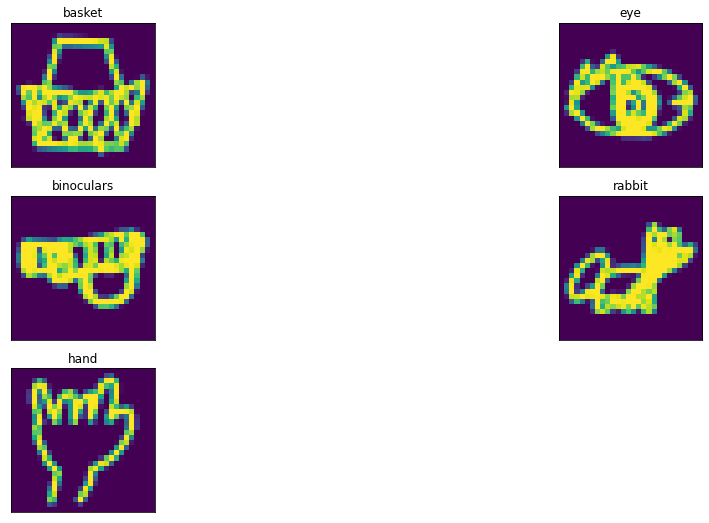

In [ ]:
plt.figure(figsize=(18,9))
for i in range(0,5):
    ax= plt.subplot(3,2 ,i+1)
    mydata = pd.read_csv("train.csv",skiprows = [1], nrows=1)
    im = Image.open('images/'+classes[i]+'/'+ os.listdir("images/"+classes[i])[0])
    fig=ax.imshow(im)
    plt.title(classes[i])
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
plt.show()    


## Chargement des données 

D'abord, il nous faut en entrée, des images sous la forme d’une matrice de pixels de 2 dimensions pour une image en niveaux de gris, la couleur est représentée par une troisième dimension, de profondeur 3 pour représenter les couleurs fondamentales [Rouge, Vert, Bleu].
Pour cela on a définit la fontion get_data qui à partir des fichiers csv train et valid parcours le dossier images pour récuperer toutes les images et les transformer en matrice de pixels pour la suite.

In [ ]:
def get_data(train, valid, img_size):
  
    xtrain = []  
    ytrain = train['class_label']
    x_valid = []
    y_valid= valid['class_label']

    for imgt in 'images/'+train['relative_path'] :
        try:
          img_t = load_img(imgt, target_size=img_size)
          img_arr_t = img_to_array(img_t)
          xtrain.append(img_arr_t)
        except Exception as e:
          print(e)
   
    x_train, x_test, y_train, y_test= train_test_split(xtrain, ytrain, test_size=0.15, random_state=42)

    for imgv in 'images/'+valid['relative_path'] : 
       try:
          img_v = load_img(imgv, target_size=img_size)
          img_arr_v = img_to_array(img_v)
          x_valid.append(img_arr_v)
       except Exception as e:
          print(e)
    
    
    return x_train, y_train, x_valid, y_valid, x_test, y_test

In [ ]:
x_train, y_train, x_valid, y_valid, x_test, y_test= get_data(train, valid, img_size)

## Prétraitement des données


In [ ]:
# Normalisation des données
X_train = np.array(x_train) / 255
X_valid = np.array(x_valid) / 255
X_test = np.array(x_test) / 255

# Convertir les vecters en matrices 
Y_train = tensorflow.keras.utils.to_categorical(y_train, num_classes)
Y_valid = tensorflow.keras.utils.to_categorical(y_valid, num_classes)
Y_test = tensorflow.keras.utils.to_categorical(y_test, num_classes)

#test
print('Train shapes      :',X_train.shape, Y_train.shape)
print('Valid shapes      :',X_valid.shape, Y_valid.shape)
print('Test shapes      :',X_valid.shape, Y_valid.shape)


Train shapes      : (63750, 28, 28, 3) (63750, 5)
Valid shapes      : (25000, 28, 28, 3) (25000, 5)
Test shapes      : (25000, 28, 28, 3) (25000, 5)


# Mise en place du modèle

## Paramètres du modèle

In [ ]:
num_epochs = 20 #30
batch_size = 256 #128
filepath = '/content/drive/MyDrive/examDL/Challenge_AAFAF_HIBA.h5' #path where to save the model

## Définition du modèle (CNN)

 Après avoir traité nos données, on va construire notre modèle. Notre choix s'est porté sur un modèle CNN composé de 10 couches (sans la couche Dropout) .L'évaluation du modèle sur les données test a donnée une précision de 94.51%. Néanmoins, On a remarqué  que l’erreur sur les données de test devient croissante ce qui montre que notre modèle est donc en overfitting.
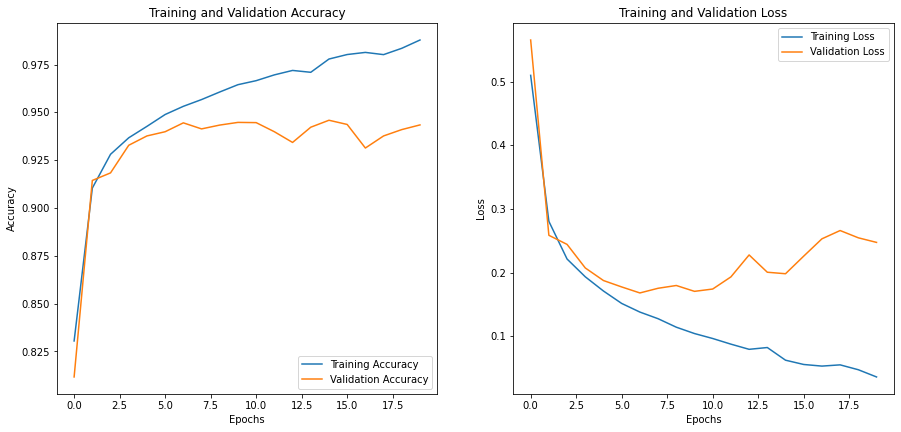

 Ainsi, l'ajout d'une couche **Dropout** après la configuration des couches convolutionnelles (MaxPooling2D et Flatten) a réglé le problème. 





In [ ]:
def MyModel(input_shape):

  model = tensorflow.keras.Sequential()
  model.add(layers.Convolution2D(16, (3, 3),
                          padding='same',
                          input_shape=input_shape, activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
  model.add(layers.MaxPooling2D(pool_size =(2,2)))
  model.add(layers.Flatten())

  # On a ajouté cette couche pour se débarrasser complètement de l’overfitting
  model.add(layers.Dropout(0.5)) 

  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(100, activation='relu')) 
  model.add(layers.Dense(5, activation='softmax')) 

  # Compile model
  model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])
    
  model.summary()

  return model

In [ ]:
model = MyModel(input_shape=X_train.shape[1:]) #img_shape

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 3, 3, 64)        

#Entrainement et Sauvegarde du modèle


Pour enregistrer la meilleure version du modèle on a utilisé les callbachs :




In [ ]:
#create callback
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=2, 
                             save_best_only=True,
                             mode='min')
callbacks = [checkpoint]

#fit the model
history = model.fit(X_train,
                  Y_train,
                  batch_size=batch_size,
                  epochs=num_epochs,
                  verbose=2,
                  validation_data=(X_valid, Y_valid),
                  callbacks=callbacks,
                  use_multiprocessing=True)


Epoch 1/20

Epoch 00001: val_loss improved from inf to 0.28159, saving model to /content/drive/MyDrive/examDL/Challenge_AAFAF_HIBA.h5
250/250 - 5s - loss: 0.5768 - accuracy: 0.7971 - val_loss: 0.2816 - val_accuracy: 0.9118 - 5s/epoch - 20ms/step
Epoch 2/20

Epoch 00002: val_loss improved from 0.28159 to 0.21968, saving model to /content/drive/MyDrive/examDL/Challenge_AAFAF_HIBA.h5
250/250 - 3s - loss: 0.2977 - accuracy: 0.9021 - val_loss: 0.2197 - val_accuracy: 0.9281 - 3s/epoch - 14ms/step
Epoch 3/20

Epoch 00003: val_loss improved from 0.21968 to 0.20484, saving model to /content/drive/MyDrive/examDL/Challenge_AAFAF_HIBA.h5
250/250 - 3s - loss: 0.2448 - accuracy: 0.9194 - val_loss: 0.2048 - val_accuracy: 0.9319 - 3s/epoch - 14ms/step
Epoch 4/20

Epoch 00004: val_loss improved from 0.20484 to 0.17223, saving model to /content/drive/MyDrive/examDL/Challenge_AAFAF_HIBA.h5
250/250 - 4s - loss: 0.2172 - accuracy: 0.9276 - val_loss: 0.1722 - val_accuracy: 0.9417 - 4s/epoch - 14ms/step
Epoc

In [ ]:
# enregistrement des poids
model.save_weights('/content/drive/MyDrive/examDL/weights.h5')

#Evaluation du modèle


Afin d'analyser le comportement de notre modèle, on va comparer les courbes de loss et les courbes de précision.

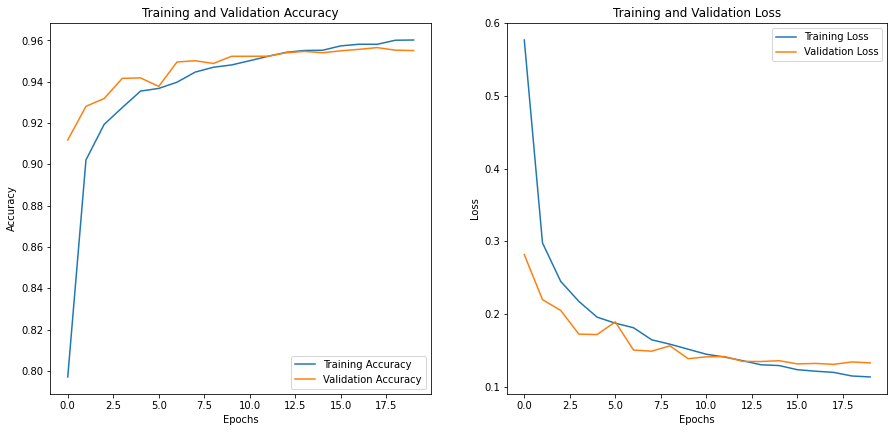

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(2, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.savefig('model_training_history')
plt.show()

Essayons notre modèle sur les données de test :

In [ ]:
#Load and evaluate the best model version
from tensorflow.keras.models import load_model 

model = load_model(filepath)

model.summary()

score = model.evaluate(X_test, Y_test, verbose=1)
print('Test loss: {:0.2f}%, Test accuracy: {:0.2f}% '.format(score[0]*100,score[1]*100) )


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 3, 3, 64)        

#Conclusion

Il s'est avéré que ce modèle CNN semble adapté à ce type de classification, il est robuste, optimal et donne une précision de de 95.8%.
On va essayer par la suite de tester ce modèle sur des images de notre choix dans le deuxième Notebook.





In [ ]:
pip freeze > '/content/drive/MyDrive/examDL/requirements.txt'